## Motor Insurance Conversion Modelling

### Background:
An insurance company is looking to optimize the sales of its motor insurance product. While thousands of
potential customers request insurance quotes, only a small percentage proceed to purchase a policy. The
portfolio manager wants to understand why some customers convert while others don’t and how to optimize
pricing and targeting strategies.

### We Are Provided With:
1. <b>Quotes & Policies Dataset</b> which contains customer quote requests and indicator whether the
quote converted into a policy.
2. <b>Vehicle Features Dataset</b> – additional information on the vehicles.

### Mission:
* Merge the dataset with vehicle features to enrich insights.
* Build a predictive model to estimate conversion probability and interpret key drivers.
* Deliver actionable insights to improve conversion rates and refine pricing strategies.

### Final Deliverables:
* Jupyter Notebook or Python script with analysis and modeling.
* Short report summarizing key findings and recommendations.

## Notebook Preparation

In [1]:
%matplotlib inline

# Third party library imports
import os
import time
import warnings
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import parallel_backend
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    cross_val_score,
    ParameterSampler
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, 
    confusion_matrix, precision_score, 
    recall_score, classification_report, 
    roc_auc_score, RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, 
    OrdinalEncoder, 
    OneHotEncoder, 
    LabelEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Local libraries
from functions.utils import (
    csv_to_parquet, 
    reduce_memory_usage_pd, 
    missing_percentage, 
    count_duplicated_rows, 
    clean_params
)
from functions.plot_utils import (
    horizontal_kde_box_plot, 
    plot_percentage_bars_categorical, 
    cm_matrix)
from functions.machine_learning_models import ml_models, ml_models_parameters

In [2]:
# Set up custom settings for plots
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
palette_cmap = sns.color_palette("mako", as_cmap=True)
colors = ['#4c72b0', '#dd8452']

In [3]:
# Data paths
data_path = "data/"
conversation_data = f"{data_path}conversion_data.parquet"
vehicle_classifier = f"{data_path}vehicle_classifier.parquet"

In [4]:
# Memory reduce
csv_to_parquet(folder_path=data_path, path_to_save=data_path, overwrite=False)

Parquet file for conversion_data.csv already exists and will not be overwritten.
Parquet file for vehicle_classifier.csv already exists and will not be overwritten.


In [5]:
# Data loading
df_cd = pd.read_parquet(conversation_data, engine="pyarrow")
df_vc = pd.read_parquet(vehicle_classifier, engine="pyarrow")

In [6]:
# Combining both datasets
df = df_cd.merge(df_vc, on="vehicle_id")

In [7]:
# Reduce memory
df = reduce_memory_usage_pd(df)

Memory before: 10.46 MB. 
Memory after: 3.23 MB.
Percent of reduction: (69.1% reduction)


## Data Cleaning
In data cleaning part we will check our data quality. We will check for any duplicate values or missing ones. First, let's check how our data looks.

In [8]:
df.shape

(80674, 17)

In [9]:
df.head()

,policy,customerage,driving_experience,other_drivers,customerlocation_gr,bonus_malus,accidents_local,accidents_abroad,fuel,vehicle_id,vehiclegroup,make,vehicleage,power,weight,engine_size,seats
0,0,33.0,14.0,>25yrs old and >2yrs experience,2,E,0.0,0.0,Gasoline,134250,3,AUDI,18,120,NaN,1900.0,5.0
1,0,37.0,9.0,>25yrs old and >2yrs experience,5,F,1.0,0.0,Gasoline,134251,4,VOLVO,23,150,1600.0,2400.0,5.0
2,0,27.0,9.0,>25yrs old and >2yrs experience,Other,I,1.0,0.0,Diesel,134252,5,BMW,20,160,1700.0,2900.0,5.0
3,0,47.0,29.0,>25yrs old and >2yrs experience,Other,A,0.0,0.0,Diesel,134253,4,OPEL,22,90,1500.0,2100.0,7.0
4,0,28.0,10.0,All drivers,Other,D,0.0,0.0,Gasoline,134254,3,AUDI,7,180,1700.0,1900.0,5.0


From first look  column other_drivers - provide combine information, column can be split into age group and experience group, 
<b>vehicle_id</b> - column is not useful for us, we can drop it.

In [10]:
count_duplicated_rows(df)

The DataFrame contains 0 duplicated rows.


In [11]:
df = df.drop(["vehicle_id"], axis=1)

In [12]:
count_duplicated_rows(df)

The DataFrame contains 5890 duplicated rows.


We can see that after removing ID duplicate values appeared, for this reason we could remove them as we need pure data, but as our data sample is very small, we need to inspect it before removing any of the data.

In [13]:
df[df.duplicated(keep="first")].sort_values(by=["make", "customerage", "power"]).value_counts("policy")

policy
0    5888
1       2
Name: count, dtype: int64

It is highly imbalanced, we have majority for policy - 0, for this reason we need to remove duplicates.

In [14]:
df = df.drop_duplicates()
count_duplicated_rows(df)

The DataFrame contains 0 duplicated rows.


In [15]:
missing_percentage(df)

,Total_missing,Percent_missing
weight,4050,5.415597
driving_experience,2499,3.341624
engine_size,2026,2.709136
seats,1385,1.852000
accidents_local,24,0.032092
accidents_abroad,24,0.032092
customerage,19,0.025407
other_drivers,0,0.000000
customerlocation_gr,0,0.000000
bonus_malus,0,0.000000


As we can see, there are no columns which have high missing value percentage which is good indicator, of course it is not perfect, but for ML model it will not make big difference. 
Looks like most of the missing data appeared from second dataset - Vehicle Features Dataset, while main Quotes & Policies Dataset driving_experience	 indicate 3.3% of missing data in the column, while other columns have less than 1%.

Now we can check categorical features

In [16]:
df["other_drivers"].unique()

['>25yrs old and >2yrs experience', 'All drivers']
Categories (2, object): ['>25yrs old and >2yrs experience', 'All drivers']

other_drivers - can provide more information about who will drive the car.

In [17]:
df["customerlocation_gr"].unique()

['2', '5', 'Other', '6', '7', ..., '3', '8', '1', '10', '9']
Length: 11
Categories (11, object): ['1', '10', '2', '3', ..., '7', '8', '9', 'Other']

In [18]:
df["bonus_malus"].unique()

['E', 'F', 'I', 'A', 'D', ..., 'H', 'J', 'C', 'B', 'K']
Length: 11
Categories (11, object): ['A', 'B', 'C', 'D', ..., 'H', 'I', 'J', 'K']

bonus_malus - is a common method that allows evaluating higher-lower risk drivers.

In [19]:
df["fuel"].unique()

['Gasoline', 'Diesel', 'Gasoline / Electric', 'Unknown', 'Electric', 'Gas']
Categories (6, object): ['Diesel', 'Electric', 'Gas', 'Gasoline', 'Gasoline / Electric', 'Unknown']

In [20]:
df["make"].unique()

['AUDI', 'VOLVO', 'BMW', 'OPEL', 'Other', ..., 'MAZDA', 'MERCEDES', 'SUBARU', 'FIAT', 'CHRYSLER']
Length: 23
Categories (23, object): ['AUDI', 'BMW', 'CHRYSLER', 'CITROEN', ..., 'SUBARU', 'TOYOTA', 'VOLVO', 'VW']

## Exploratory Data Analysis
We will start our EDA step with analyzing part of the dataset. To avoid overfitting and data leakage, we will explore only train dataset. For this we will split our dataset to train test valid later.

In [21]:
df.columns = [col.upper() for col in df.columns]

In [22]:
df.head()

,POLICY,CUSTOMERAGE,DRIVING_EXPERIENCE,OTHER_DRIVERS,CUSTOMERLOCATION_GR,BONUS_MALUS,ACCIDENTS_LOCAL,ACCIDENTS_ABROAD,FUEL,VEHICLEGROUP,MAKE,VEHICLEAGE,POWER,WEIGHT,ENGINE_SIZE,SEATS
0,0,33.0,14.0,>25yrs old and >2yrs experience,2,E,0.0,0.0,Gasoline,3,AUDI,18,120,NaN,1900.0,5.0
1,0,37.0,9.0,>25yrs old and >2yrs experience,5,F,1.0,0.0,Gasoline,4,VOLVO,23,150,1600.0,2400.0,5.0
2,0,27.0,9.0,>25yrs old and >2yrs experience,Other,I,1.0,0.0,Diesel,5,BMW,20,160,1700.0,2900.0,5.0
3,0,47.0,29.0,>25yrs old and >2yrs experience,Other,A,0.0,0.0,Diesel,4,OPEL,22,90,1500.0,2100.0,7.0
4,0,28.0,10.0,All drivers,Other,D,0.0,0.0,Gasoline,3,AUDI,7,180,1700.0,1900.0,5.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74784 entries, 0 to 80672
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   POLICY               74784 non-null  int8    
 1   CUSTOMERAGE          74765 non-null  float32 
 2   DRIVING_EXPERIENCE   72285 non-null  float32 
 3   OTHER_DRIVERS        74784 non-null  category
 4   CUSTOMERLOCATION_GR  74784 non-null  category
 5   BONUS_MALUS          74784 non-null  category
 6   ACCIDENTS_LOCAL      74760 non-null  float32 
 7   ACCIDENTS_ABROAD     74760 non-null  float32 
 8   FUEL                 74784 non-null  category
 9   VEHICLEGROUP         74784 non-null  int8    
 10  MAKE                 74784 non-null  category
 11  VEHICLEAGE           74784 non-null  int8    
 12  POWER                74784 non-null  int16   
 13  WEIGHT               70734 non-null  float32 
 14  ENGINE_SIZE          72758 non-null  float32 
 15  SEATS                733

After cleaning the data, we have 74784 rows of data with 16 features. Most of the features are numeric type and 5 features are categorical, categorical features can be inspected to get more information later.

#### Dealing With Outliers

In [24]:
df.describe()

,POLICY,CUSTOMERAGE,DRIVING_EXPERIENCE,ACCIDENTS_LOCAL,ACCIDENTS_ABROAD,VEHICLEGROUP,VEHICLEAGE,POWER,WEIGHT,ENGINE_SIZE,SEATS
count,74784.000000,74765.000000,72285.000000,74760.000000,74760.000000,74784.000000,74784.000000,74784.000000,70734.000000,72758.000000,73399.000000
mean,0.053875,41.243042,18.990358,0.399973,0.005190,3.252367,16.709818,108.974781,1535.715454,2037.522705,5.191461
std,0.225773,13.486870,11.000082,0.715218,0.074952,1.064418,5.825443,39.502661,273.438843,564.656311,0.758221
min,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,700.000000,500.000000,2.000000
25%,0.000000,31.000000,10.000000,0.000000,0.000000,3.000000,13.000000,80.000000,1400.000000,1800.000000,5.000000
50%,0.000000,39.000000,17.000000,0.000000,0.000000,3.000000,17.000000,100.000000,1500.000000,1900.000000,5.000000
75%,0.000000,51.000000,27.000000,1.000000,0.000000,4.000000,20.000000,130.000000,1700.000000,2400.000000,5.000000
max,1.000000,80.000000,50.000000,5.000000,2.000000,5.000000,30.000000,300.000000,3000.000000,5000.000000,9.000000


No outliers, highly imbalanced POLICY.

#### Policy Distribution

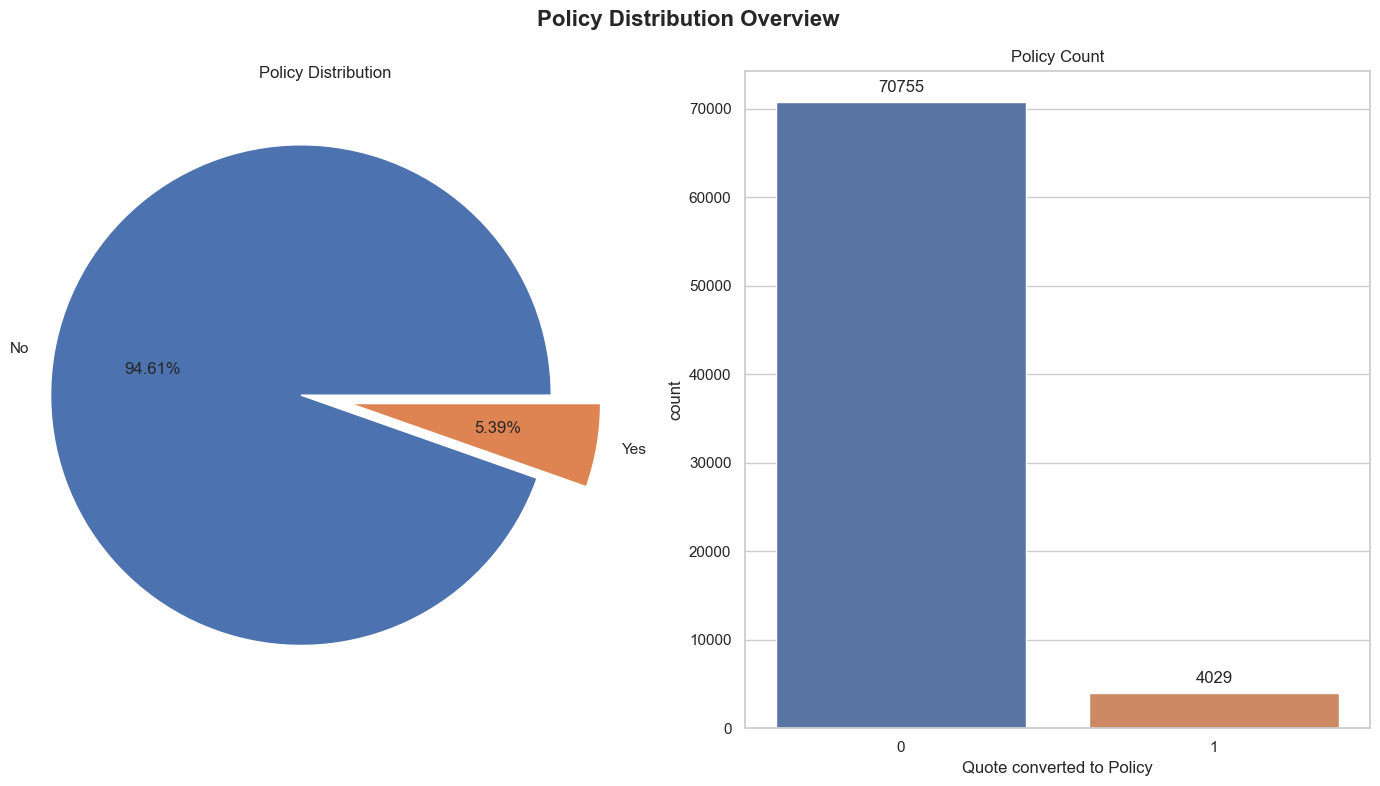

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].pie(
    x=df["POLICY"].value_counts(), 
    labels=["No", "Yes"], 
    autopct="%1.2f%%", 
    explode=[0.1, 0.1]
)

sns.countplot(
    data=df, 
    x="POLICY", 
    ax=axes[1],
    palette=colors)

for container in axes[1].containers:
    axes[1].bar_label(container, padding=5)

axes[0].set_title("Policy Distribution")
axes[1].set_title("Policy Count")
axes[1].set_xlabel("Quote converted to Policy")

fig.suptitle(
    "Policy Distribution Overview", 
    fontsize=16, fontweight='bold')

plt.tight_layout();

Policy distribution is not equal, from all 74784 Quotes we have only 5.39% which was converted to Policy. It is high disbalance of the data which will lead to lover accuracy of the model, so we will need to take this into account. 

Before moving forward, we can split our data here.

In [26]:
x = df.iloc[:, 1:]
y = df.iloc[:, 0]

df_train, df_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

In [27]:
df_train_merge = pd.concat([y_train, df_train], axis=1)

#### Age distribution

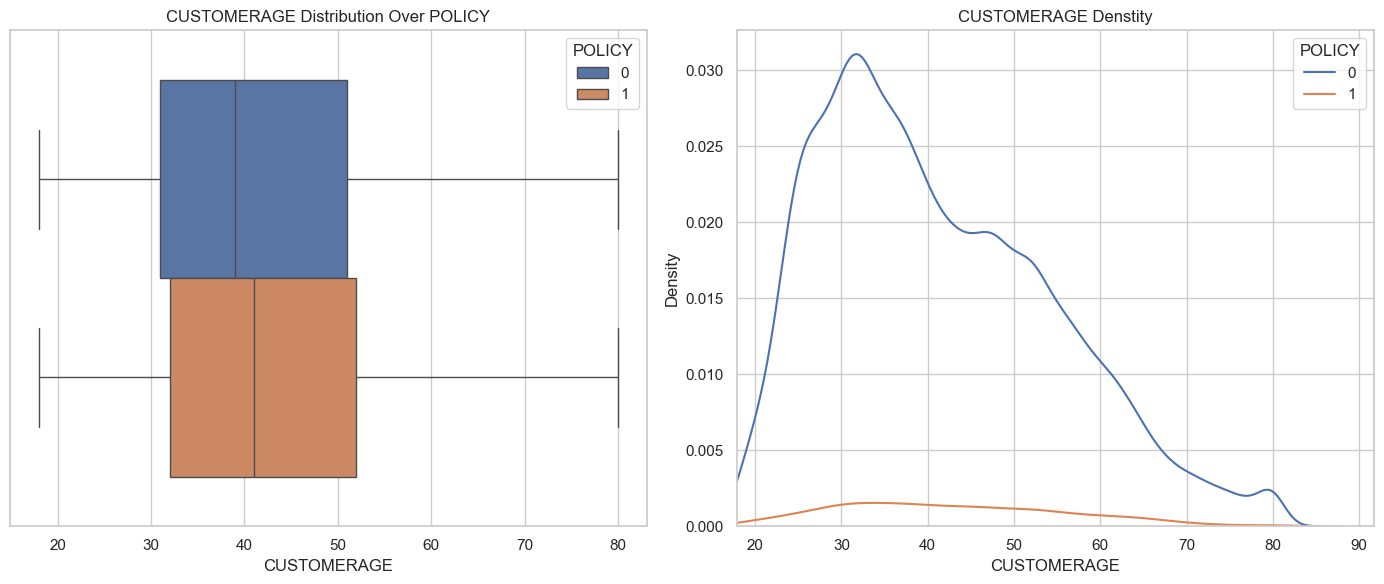

In [28]:
horizontal_kde_box_plot(
    df=df_train_merge, x="CUSTOMERAGE", hue="POLICY")

Most of the customers are 31-52 years old.
Youngest - 18, Oldest - 80
Average - 40
Biggest density indicates that 32 years ole customers most often check for policy.

#### Driving experience distribution

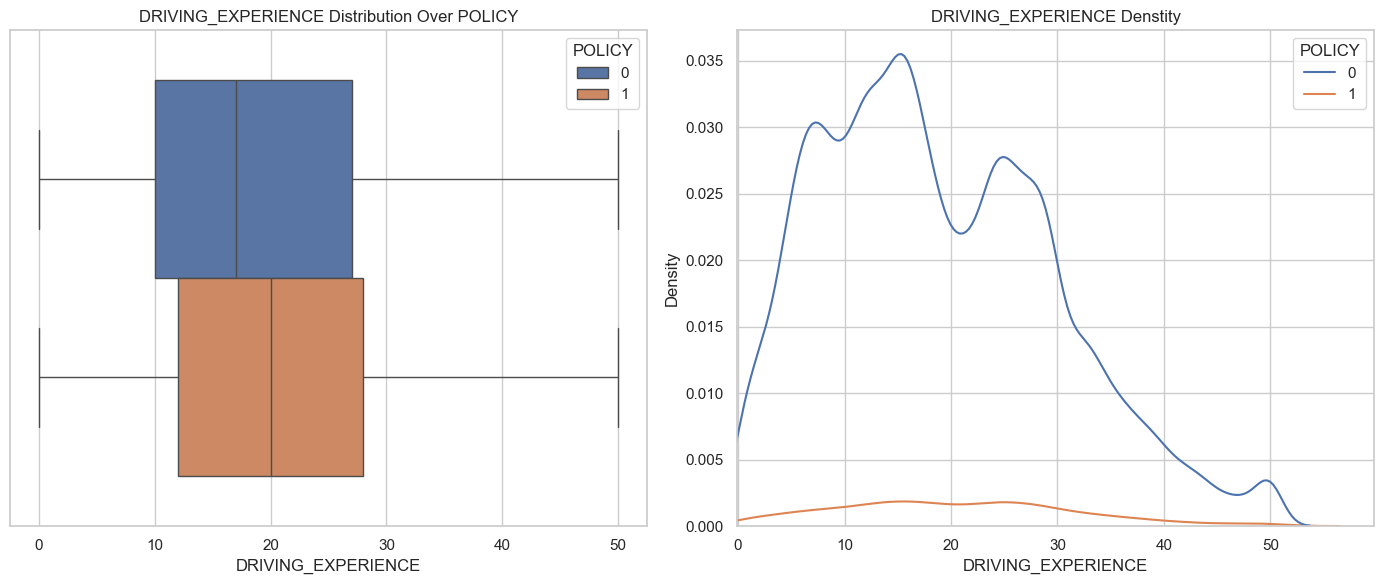

In [29]:
horizontal_kde_box_plot(
    df=df_train_merge, x="DRIVING_EXPERIENCE", hue="POLICY")

- Driving experience show that most people have 10-28 years of experience, while average is 17-20.
- Density plot indicates 4 spikes: 8, 15, 25 and 50 years of experience. 
- The density for **POLICY=0** is consistently lower than **POLICY=1**, meaning driving experience alone have increase conversion.

#### Vehicle age distribution

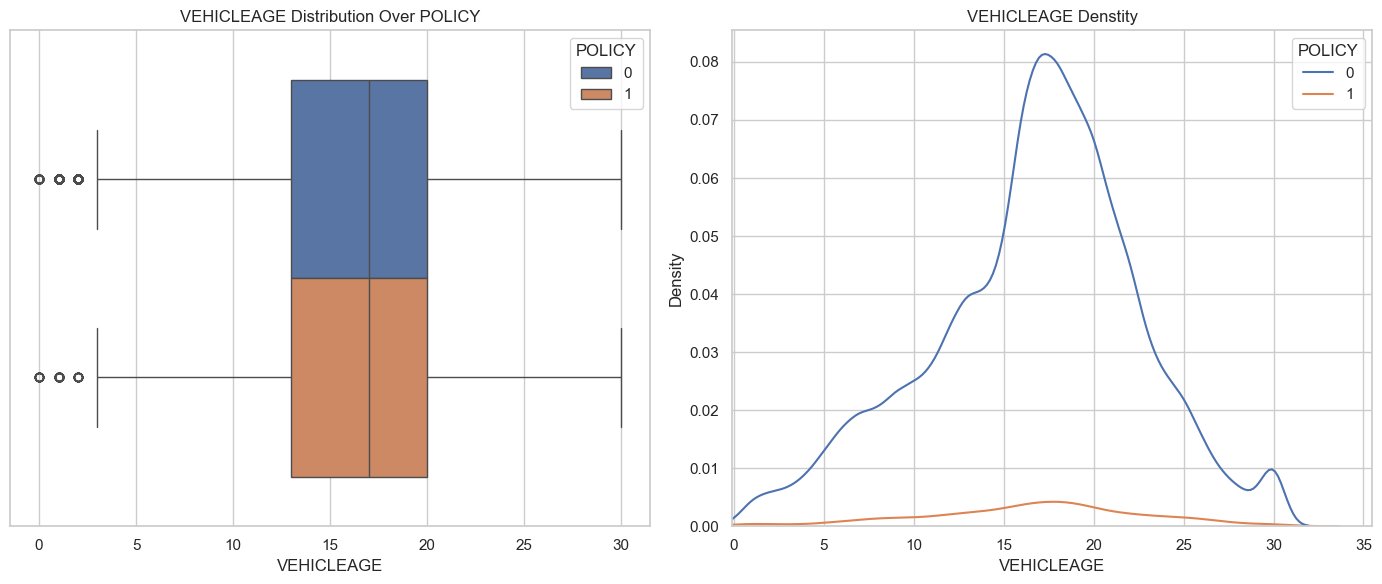

In [30]:
horizontal_kde_box_plot(
    df=df_train_merge, x="VEHICLEAGE", hue="POLICY")

- Most vehicles are 4–30 years old.
- Peak vehicle age is about 14–20 years.

#### Fuel distribution

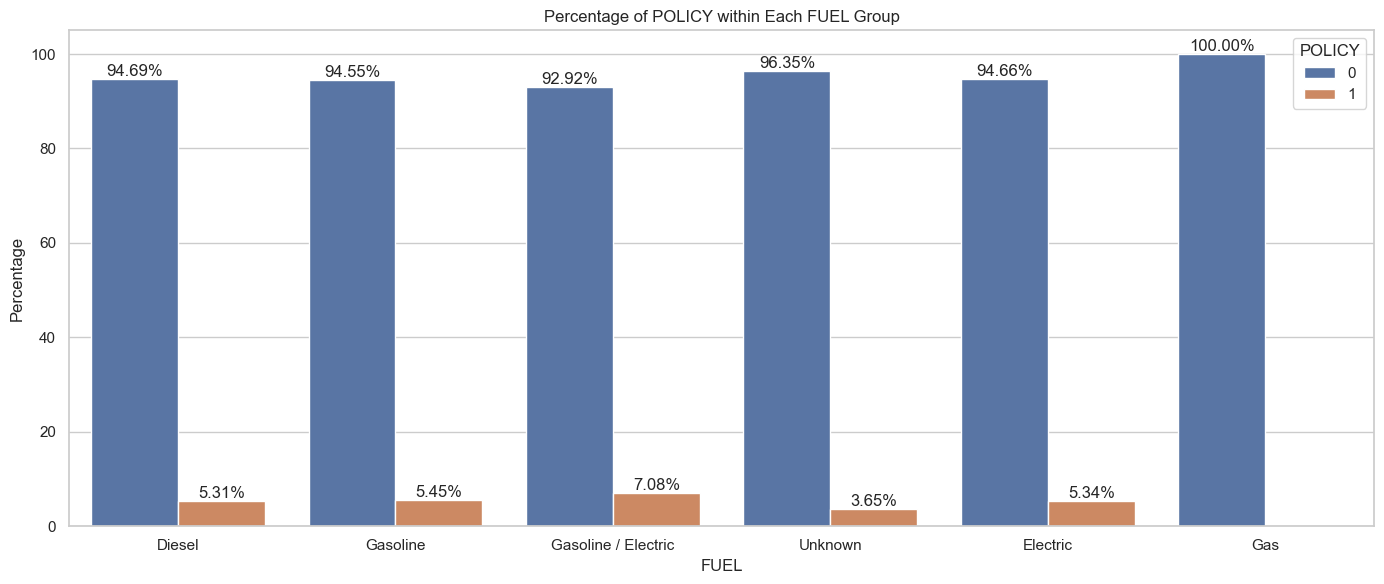

In [31]:
plot_percentage_bars_categorical(
    data=df_train_merge, x_feature="FUEL", 
    target_feature="POLICY", max_values=6);

- Very interesting, chart show that customers with fuel type of Gas(LPG) Quotes not concerts to Policy.
- Gasoline/Electric shows 7.08% conversation percentage, which is the highest among all types, difference between other groups are more than 1.5%.
- Gasoline/Electric customers are more likely to convert than others — a potential target segment.

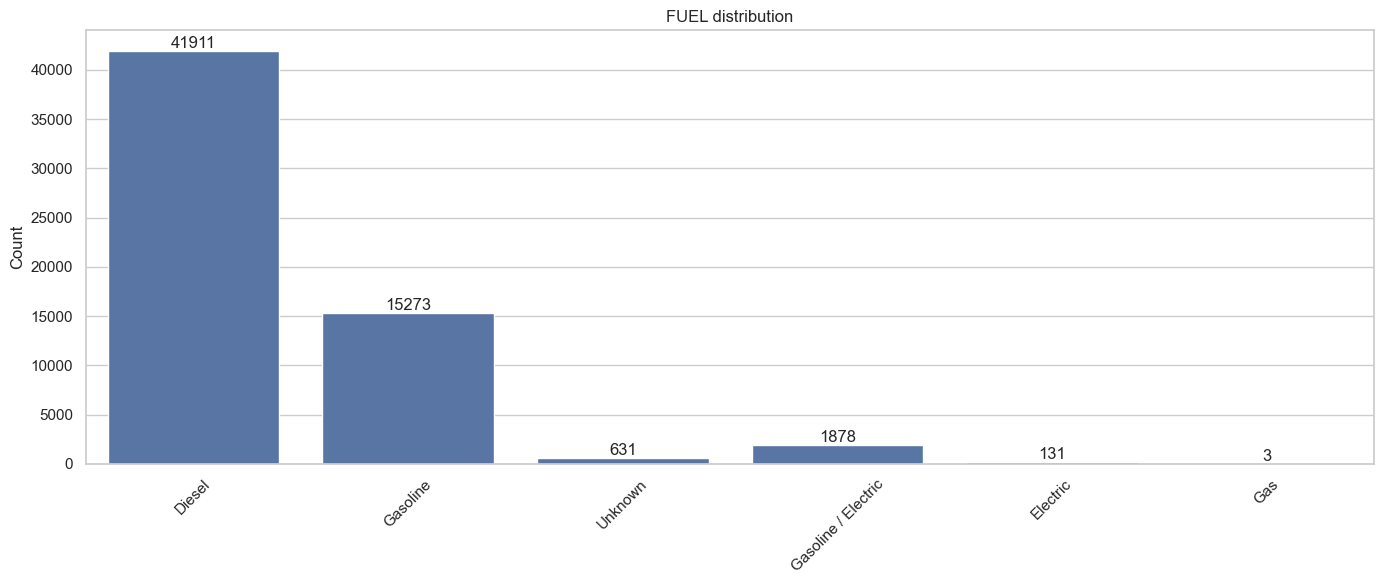

In [32]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df_train_merge, x="FUEL")

ax.tick_params(axis="x", rotation=45)
ax.bar_label(ax.containers[0])

ax.set_title("FUEL distribution")
ax.set_xlabel("")
ax.set_ylabel("Count")

plt.tight_layout()

- We have only **3 rows** of data where customer have **Gas** type of vehicle, it will bias our model we should think if fuel type is good feature for ML.
- One of the solutions combine **Gas** and **Electrcic** with **Unknown**.

#### Bonus Malus distribution 

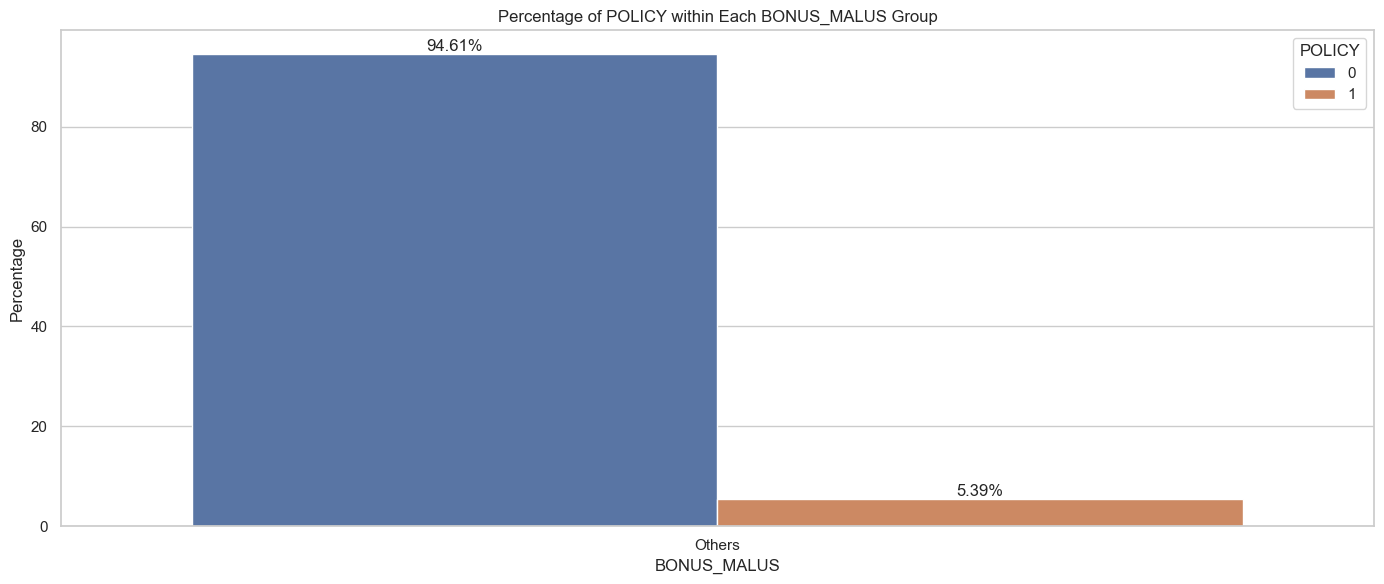

In [33]:
plot_percentage_bars_categorical(
    data=df_train_merge, x_feature="BONUS_MALUS", 
    target_feature="POLICY", max_values=0);

- Only <b>5.39%</b> of the total quotes were converted into policies.
- The remaining <b>94.61%</b> were not converted, suggesting a significant imbalance.

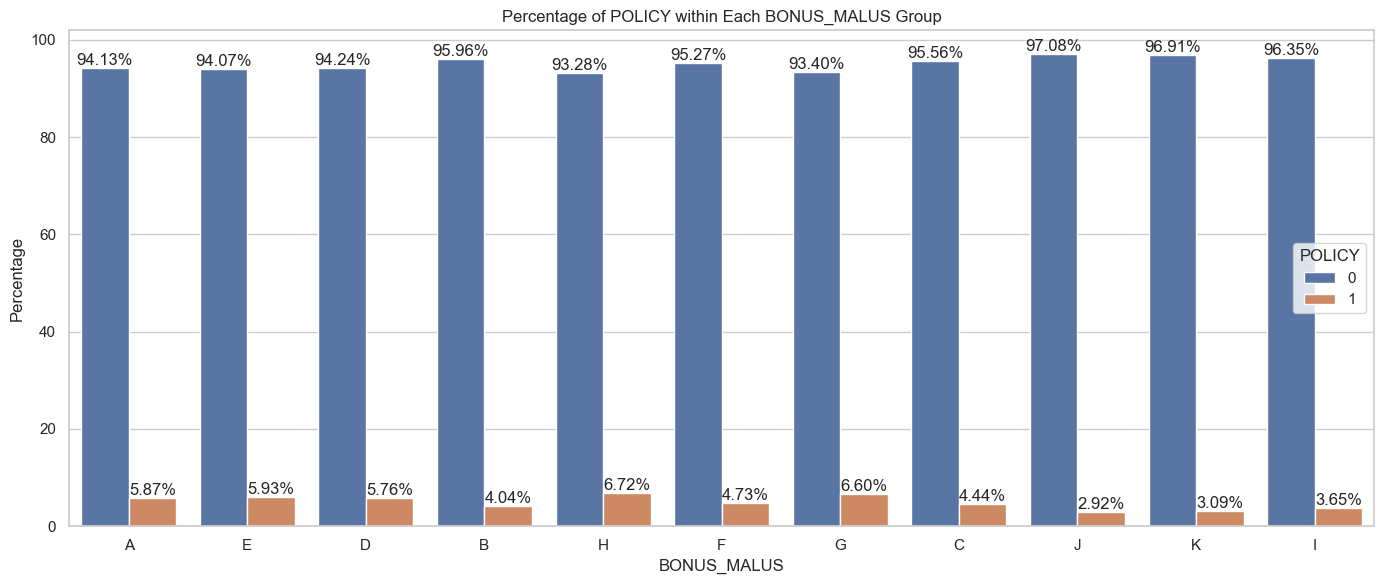

In [34]:
plot_percentage_bars_categorical(
    data=df_train_merge, x_feature="BONUS_MALUS", 
    target_feature="POLICY", max_values=11);

- **A, E, H and G** groups have the highest Policy percentage **+5%**.
- The **average** is **5.39%** and the lowest groups are J - 2.92% and K - 3.09%, which are more than 2% difference that average.
- Investigate why groups are different, investigate key areas (pricing, communication, offers).

### Feature Enginnering

An important step of good ML is feature engineering. We got some ensigns from EDA which can help us to create additional features.

Like we saw before our dataset have ACCIDENTS, we could create additional feature which will indicate overall sum of accidents and also additional feature which will show if customer have accidents or no.

In [35]:
df_train_merge["TOTAL_ACCIDENTS"] = (
    df_train_merge["ACCIDENTS_LOCAL"] + df_train_merge["ACCIDENTS_ABROAD"])
df_test["TOTAL_ACCIDENTS"] = (
    df_test["ACCIDENTS_LOCAL"] + df_test["ACCIDENTS_ABROAD"])

In [36]:
df_train_merge["HAVE_ACCIDENTS"] = (
    df_train_merge["TOTAL_ACCIDENTS"] > 0).astype(int)
df_test["HAVE_ACCIDENTS"] = (
    df_test["TOTAL_ACCIDENTS"] > 0).astype(int)

OTHER_DRIVERS can be split to know if driver will be with experience or not.

In [37]:
df_train_merge["DRIVERS_WITH_EXPERIENCE"] = (df_train_merge["OTHER_DRIVERS"] == ">25yrs old and >2yrs experience").astype(int)
df_test["DRIVERS_WITH_EXPERIENCE"] = (df_test["OTHER_DRIVERS"] == ">25yrs old and >2yrs experience").astype(int)

Combination of **FUEL** type as we have some types with very low data points.

In [38]:
df_train_merge["FUEL"] = np.where(df_train_merge["FUEL"].isin(["Gas", "Electric"]), "Unknown", df_train_merge["FUEL"])
df_test["FUEL"] = np.where(df_test["FUEL"].isin(["Gas", "Electric"]), "Unknown", df_test["FUEL"])

It should be wise to have a column which indicates percentage accident per year it will normalize our data.

In [39]:
df_train_merge["YEARLY_ACCIDENTS_PERC"] = np.where(
    (df_train_merge["TOTAL_ACCIDENTS"] == 0) | (df_train_merge["DRIVING_EXPERIENCE"] == 0),
    0,
    round(df_train_merge["TOTAL_ACCIDENTS"] / df_train_merge["DRIVING_EXPERIENCE"], 2)
)

df_test["YEARLY_ACCIDENTS_PERC"] = np.where(
    (df_test["TOTAL_ACCIDENTS"] == 0) | (df_test["DRIVING_EXPERIENCE"] == 0),
    0,
    round(df_test["TOTAL_ACCIDENTS"] / df_test["DRIVING_EXPERIENCE"], 2)
)

Knowing engine efficiency and acceleration potential can help us indicate more information by reducing feature count.

In [40]:
df_train_merge["ACCELERATION"] = (
    df_train_merge["POWER"] / df_train_merge["WEIGHT"])
df_train_merge["LOG_ACCELERATION"] = np.log1p(df_train_merge["ACCELERATION"])

df_test["ACCELERATION"] = (
    df_test["POWER"] / df_test["WEIGHT"])
df_test["LOG_ACCELERATION"] = np.log1p(df_test["ACCELERATION"])

In [41]:
df_train_merge["POWER_PER_LITER"] = (
    df_train_merge["POWER"] / df_train_merge["ENGINE_SIZE"])
df_train_merge["LOG_POWER_PER_LITER"] = np.log1p(df_train_merge["POWER_PER_LITER"])

df_test["POWER_PER_LITER"] = (
    df_test["POWER"] / df_test["ENGINE_SIZE"])
df_test["LOG_POWER_PER_LITER"] = np.log1p(df_test["POWER_PER_LITER"])

Adding feature which will show when the customer start driving also could be wise, also having flag to know if customer have experience or not provide additional information if customer will drive or different person use the car.

In [42]:
df_train_merge["AGE_START_DRIVING"] = (
    df_train_merge["CUSTOMERAGE"] - df_train_merge["DRIVING_EXPERIENCE"])
df_train_merge["START_DRIVING_GROUP"] = pd.cut(
    df_train_merge["AGE_START_DRIVING"],
    bins=[0, 16, 18, 21, 25, 40, 100],
    labels=["too_young", "teen", "young_adult", "adult", "experienced", "senior"]
)


df_test["AGE_START_DRIVING"] = (
    df_test["CUSTOMERAGE"] - df_test["DRIVING_EXPERIENCE"])
df_test["START_DRIVING_GROUP"] = pd.cut(
    df_test["AGE_START_DRIVING"],
    bins=[0, 16, 18, 21, 25, 40, 100],
    labels=["too_young", "teen", "young_adult", "adult", "experienced", "senior"]
)

In [43]:
df_train_merge["HAVE_DRIVING_EXPERIENCE"] = (
    (df_train_merge["DRIVING_EXPERIENCE"] > 0).astype(int))
df_test["HAVE_DRIVING_EXPERIENCE"] = (
    (df_test["DRIVING_EXPERIENCE"] > 0).astype(int))

#### Accidents distribution

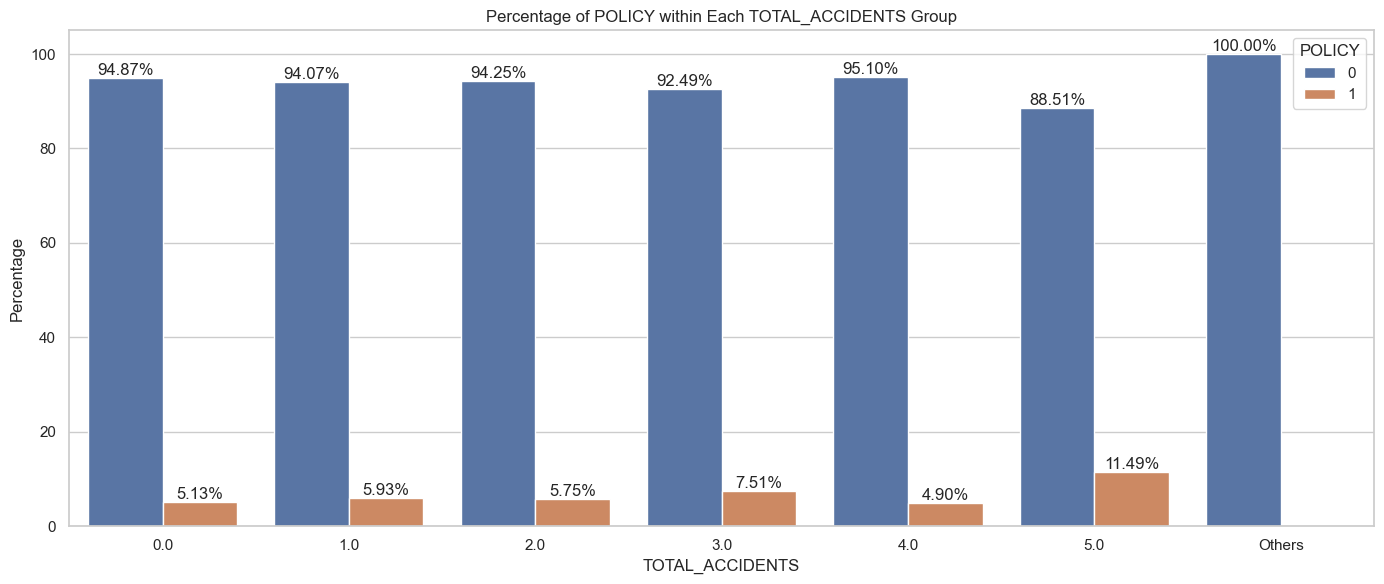

In [44]:
plot_percentage_bars_categorical(
    data=df_train_merge, x_feature="TOTAL_ACCIDENTS", 
    target_feature="POLICY", max_values=6)

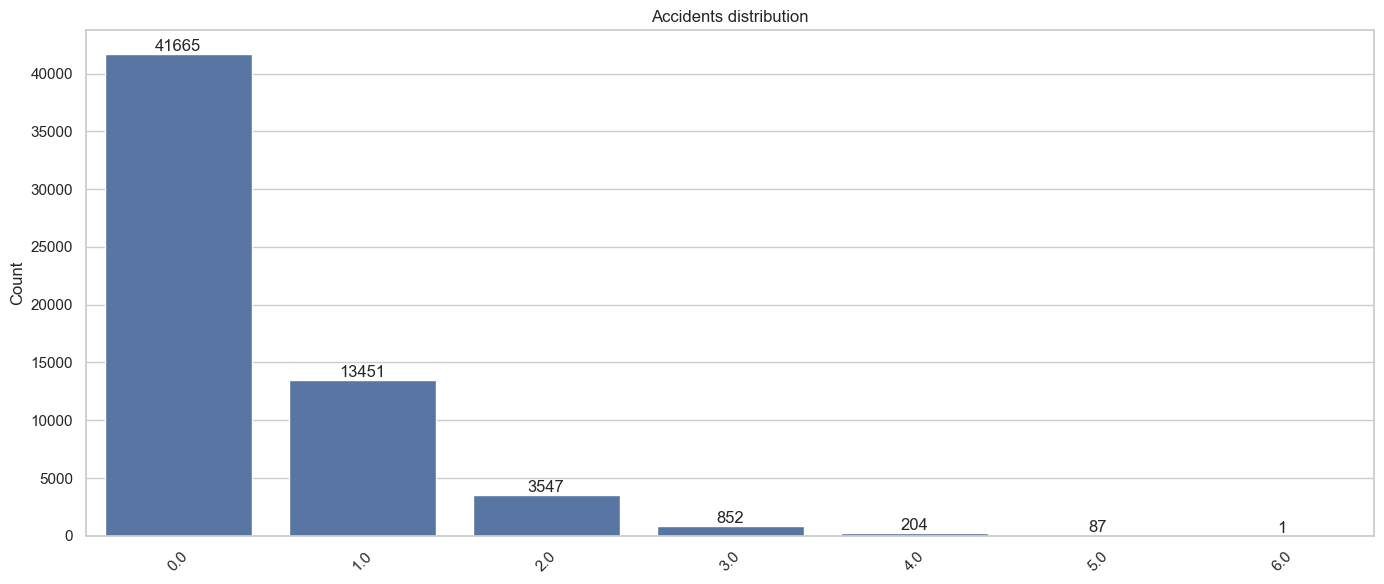

In [45]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df_train_merge, x="TOTAL_ACCIDENTS")

ax.tick_params(axis="x", rotation=45)
ax.bar_label(ax.containers[0])

ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_title("Accidents distribution")

plt.tight_layout()

- By combining accidents, we can see that Quote conversation to Policy percentage have strong relationship with total accident value.

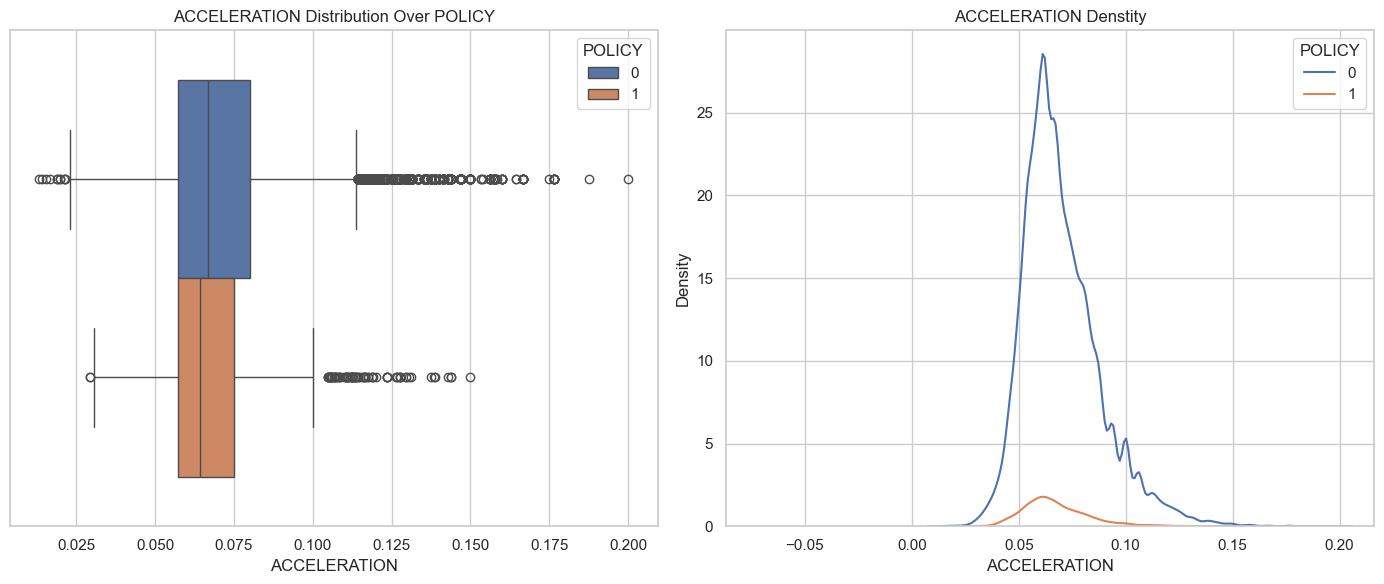

In [46]:
horizontal_kde_box_plot(
    df=df_train_merge, x="ACCELERATION", hue="POLICY")

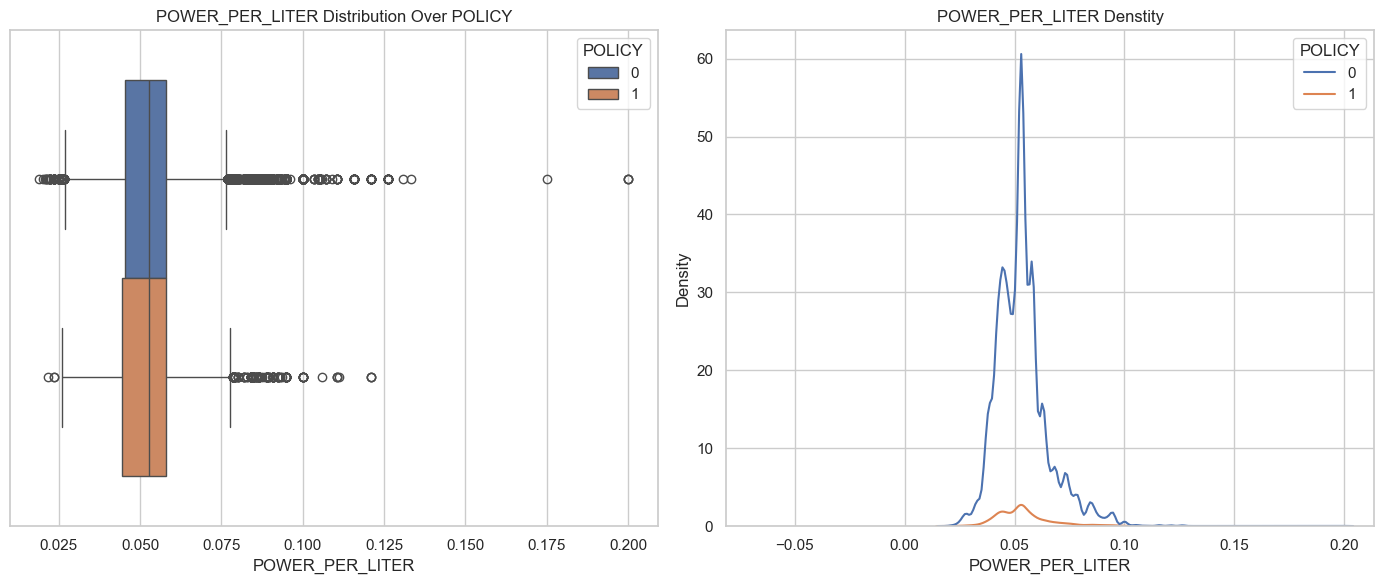

In [47]:
horizontal_kde_box_plot(
    df=df_train_merge, x="POWER_PER_LITER", hue="POLICY")

These plots show the distribution of two created vehicle performance features: **ACCELERATION** and **POWER_PER_LITER** they both are split by  **converted** (POLICY = 1) or **did not convert** (POLICY = 0).

**ACCELERATION**
- **Boxplot**: Customers who converted (`POLICY = 1`) tend to have slightly lower acceleration values compared to non-converters.
- **KDE Plot**: Both classes are right-skewed, but converters have a noticeably tighter distribution and lower overall density.
  
**POWER_PER_LITER**
- **Boxplot**: The distribution of `POWER_PER_LITER` shows a similar pattern to acceleration.
- **KDE Plot**: The majority of customers cluster around ~0.05, but those who converted have slightly lower outliers.

Insight:
- Customers with vehicles that accelerate slower may be **more likely to convert**, possibly due to driving more modest or economical cars.
- Vehicles with **lower engine power efficiency** (per liter) seem more likely to result in a policy purchase — this could reflect insurance affordability or driver intent.
- Both `ACCELERATION` and `POWER_PER_LITER` show **differentiating patterns** between converters and non-converters.
- These features may serve as **useful predictors** in the classification model and help refine customer segmentation based on vehicle performance.

#### Feature correlation

As we add new features we need to check if we have any high correlation with **Policy** feature or multicollinearity which indicator will be correlation between features more than 85%, if yes we should remove those features as they overfit our ML model.

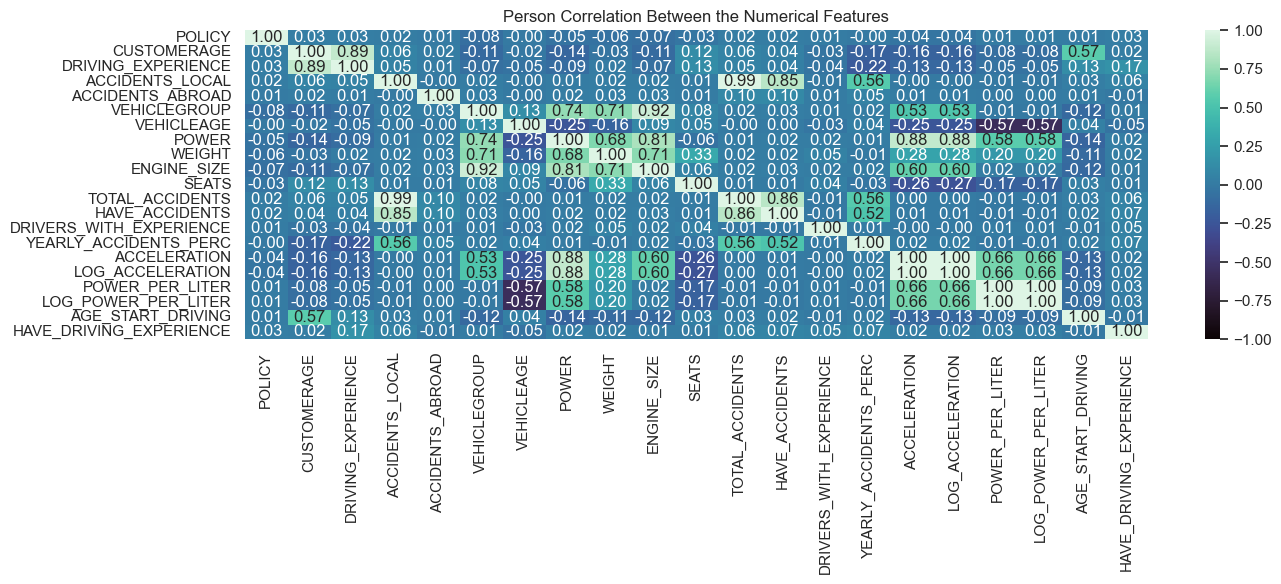

In [48]:
plt.figure(figsize=(14, 6))
corr = df_train_merge.select_dtypes(include=[np.number]).corr()

# Plot
heatmap = sns.heatmap(
    corr, vmin=-1, vmax=1, annot=True, 
    fmt=".2f", cmap=palette_cmap)
plt.title("Person Correlation Between the Numerical Features")
plt.tight_layout();

- As we have **TOTAL_ACCIDENTS**, we can drop **ACCIDENTS_LOCAL** and **ACCIDENTS_ABROAD** to reduce multicollinearity. 
- Also, we can see that **AGE_START_DRIVING** has an average correlation with **CUSTOMERAGE** but a low correlation with **DRIVING_EXPERIENCE**, which indicates that it provides new information to the model. 
- Since **CUSTOMERAGE** shows high correlation with **DRIVING_EXPERIENCE**, and we already have the derived feature **AGE_START_DRIVING**, we can safely remove **DRIVING_EXPERIENCE** from the dataset.

In [49]:
df_train_merge = df_train_merge.drop(
    ["ACCIDENTS_LOCAL", "ACCIDENTS_ABROAD", "DRIVING_EXPERIENCE", 
     "POWER", "WEIGHT", "ENGINE_SIZE", "TOTAL_ACCIDENTS", 
     "POWER_PER_LITER", "ACCELERATION"], 
    axis=1)
df_test = df_test.drop(
    ["ACCIDENTS_LOCAL", "ACCIDENTS_ABROAD", "DRIVING_EXPERIENCE", 
     "POWER", "WEIGHT", "ENGINE_SIZE", "TOTAL_ACCIDENTS", 
     "POWER_PER_LITER", "ACCELERATION"], 
    axis=1)

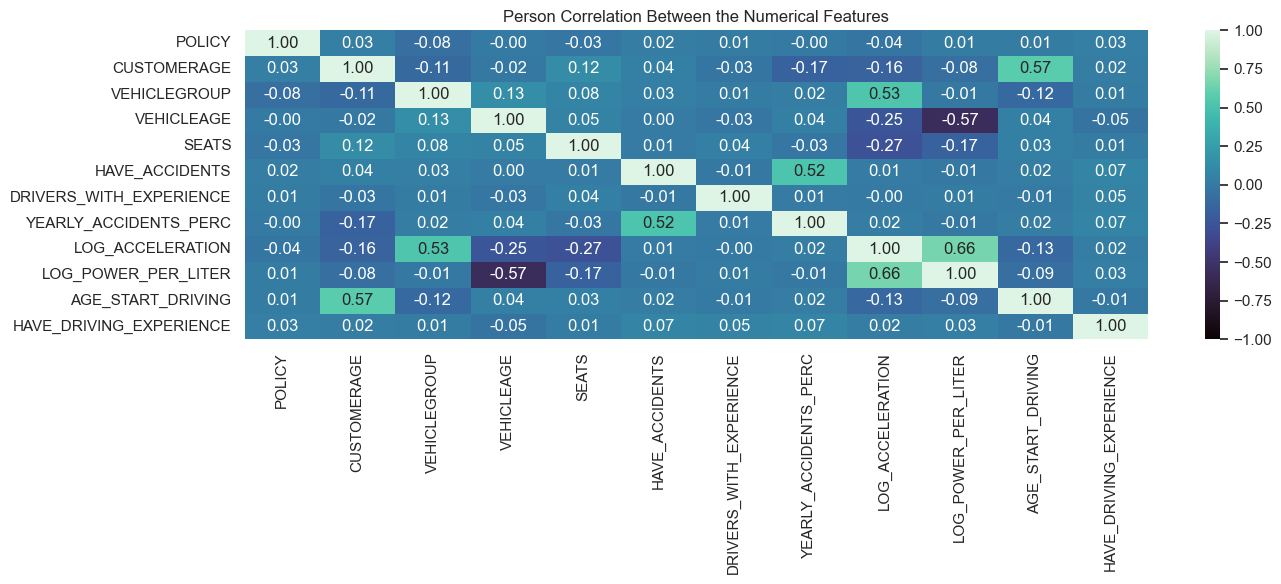

In [50]:
plt.figure(figsize=(14, 6))
corr = df_train_merge.select_dtypes(include=[np.number]).corr()

# Plot
heatmap = sns.heatmap(
    corr, vmin=-1, vmax=1, annot=True, 
    fmt=".2f", cmap=palette_cmap)
plt.title("Person Correlation Between the Numerical Features")
plt.tight_layout();

- No features show strong linear correlation with POLICY
- **CUSTOMERAGE** and **AGE_START_DRIVING** are moderately correlated (0.57) — these may carry overlapping information and could be considered for dimensionality reduction.
- **LOG_ACCELERATION**:
  - Positively correlated with **LOG_POWER_PER_LITER** (0.66), indicating both reflect vehicle performance.
  - Positively correlated with **VEHICLEGROUP** (0.53), certain vehicle groups consistently have higher acceleration.
  - Negatively correlated with **VEHICLEAGE** (-0.25), as expected, newer vehicles tend to have better acceleration.
- **LOG_POWER_PER_LITER**:
  -  Negatively correlated with **VEHICLEAGE** (-0.57), older vehicles tend to have lower engine efficiency
- **HAVE_ACCIDENTS** and **TOTAL_ACCIDENTS** are highly correlated (0.86), so one of them (usually the binary flag) may be enough for modeling.

## Machine Learning
Base by our dataset, we will create ML model which will predict if customer Quote will be converted to Policy.

Before moving forward, we need to split our test dataset to test and train.

In [51]:
y_train = df_train_merge["POLICY"]
df_train = df_train_merge.drop(columns="POLICY")

In [52]:
df_test, df_valid, y_test, y_valid = train_test_split(
    df_test, y_test, 
    stratify=y_test, 
    test_size=0.5, 
    random_state=42
)

In EDA step, we saw that some of the features have widely scaled, so we will use StandardScaler to standardize features by removing the mean and scaling to unit variance. We also use OrdinalEncoder to encode categorical features as an integer array and OrdinalEncoder as we have features which provides order. We will wrap those steps to pipeline to make our models scalable.

In [53]:
df_train_merge.columns

Index(['POLICY', 'CUSTOMERAGE', 'OTHER_DRIVERS', 'CUSTOMERLOCATION_GR',
       'BONUS_MALUS', 'FUEL', 'VEHICLEGROUP', 'MAKE', 'VEHICLEAGE', 'SEATS',
       'HAVE_ACCIDENTS', 'DRIVERS_WITH_EXPERIENCE', 'YEARLY_ACCIDENTS_PERC',
       'LOG_ACCELERATION', 'LOG_POWER_PER_LITER', 'AGE_START_DRIVING',
       'START_DRIVING_GROUP', 'HAVE_DRIVING_EXPERIENCE'],
      dtype='object')

In [54]:
num_features = [
    "CUSTOMERAGE", "VEHICLEAGE", "SEATS",
    "YEARLY_ACCIDENTS_PERC", "LOG_ACCELERATION",
    "LOG_POWER_PER_LITER", "AGE_START_DRIVING"
]

cat_features = [
    "OTHER_DRIVERS", "CUSTOMERLOCATION_GR", "FUEL", 
    "VEHICLEGROUP", "MAKE", "DRIVERS_WITH_EXPERIENCE",
    "HAVE_DRIVING_EXPERIENCE", "HAVE_ACCIDENTS"
]

ord_features = ["BONUS_MALUS", "START_DRIVING_GROUP"]
bonus_malus_order = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
start_driving_order = ["too_young", "teen", "young_adult", "adult", "experienced", "senior"]

In [55]:
def get_preprocessor(scale_numeric=True):
    # Numerical transformers
    num_transformer_scaled = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    num_transformer_unscaled = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])
    
    # Use scaled or unscaled
    num_pipe = num_transformer_scaled if scale_numeric else num_transformer_unscaled

    # Categorical and ordinal stay the same
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    
    ord_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(
            categories=[bonus_malus_order, start_driving_order],
            handle_unknown="use_encoded_value",
            unknown_value=-1))
    ])
    
    return ColumnTransformer(transformers=[
        ("numeric", num_pipe, num_features),
        ("categorical", cat_transformer, cat_features),
        ("ordinal", ord_transformer, ord_features)
    ])

As we prepared pipelines for the model, first we need to create a baseline for the model, for this we will use Random Forest Classifier with balance strategy as our data is highly imbalanced. 

In [56]:
dummy_model = RandomForestClassifier(class_weight="balanced")
preprocessor = get_preprocessor(scale_numeric="False")

dummy_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", dummy_model)])

dummy_pipeline.fit(df_train, y_train)

dummy_predictions = dummy_pipeline.predict(df_valid)

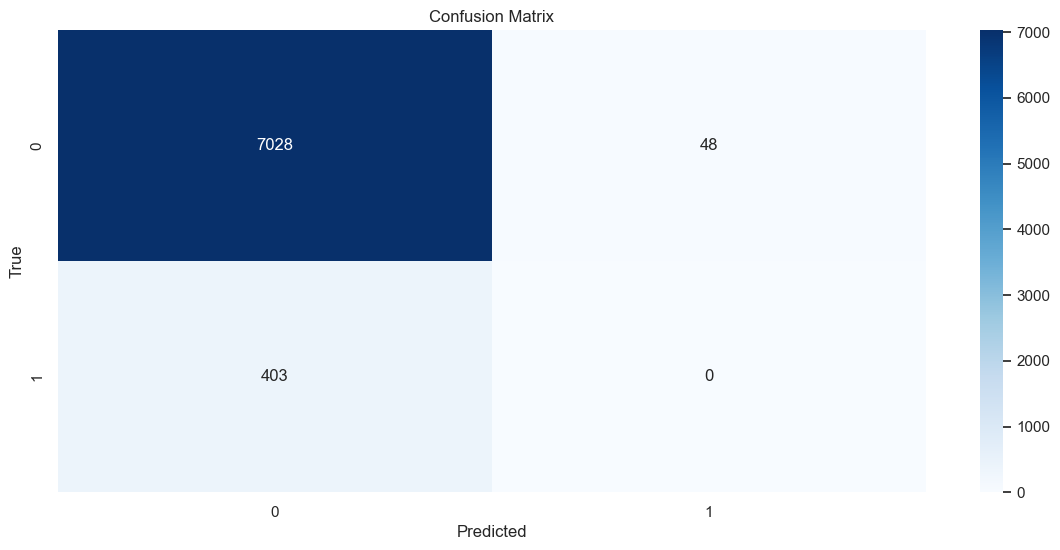

In [57]:
cm = confusion_matrix(y_valid, dummy_predictions)

plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".4g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix");

In [58]:
print(classification_report(y_valid, dummy_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7076
           1       0.00      0.00      0.00       403

    accuracy                           0.94      7479
   macro avg       0.47      0.50      0.48      7479
weighted avg       0.89      0.94      0.92      7479



For a dummy model it is not bad results while we didn't tune any parameters, but as data is imbalanced, it will most of the time guess output 0 for Quote conversation to Policy.

### Hyperparameter Tuning

We get our **threshold**, which will be our **baseline** for evaluating the models.

Since we've already imported the machine learning models and their parameters from the **machine_learning_models** file, we can now proceed to **combine our models**, use **RandomizedSearchCV** for **hyperparameter tuning**, fit the models, and evaluate their results.

## Models Overview

We will use the following **six models**:

### 1. Logistic Regression

- A straightforward model that is **easy to understand and interpret**.
- Provides insights into **feature importance** through its coefficients.
- With `class_weight='balanced'`, it can handle **class imbalance** by adjusting weights based on class frequencies.

### 2. Random Forest Classifier

- An **ensemble method** that combines multiple decision trees for improved accuracy and robustness.
- Reduces the risk of **overfitting** compared to individual decision trees.
- Supports class imbalance handling with `class_weight='balanced'`.

### 3. Histogram-Based Gradient Boosting (HistGB)
- A **high-performance gradient boosting model** built into scikit-learn.
- **Much faster** than traditional Gradient Boosting due to histogram-based optimizations.
- Natively supports **missing values** and handles large datasets efficiently.
- A great alternative to LightGBM and XGBoost for fast iteration and strong performance.

### 4. XGBoost

- Renowned for **speed and performance**.
- Includes **L1 and L2 regularization** to reduce overfitting.
- A **powerful choice** for predictive modeling tasks.

### 5. K-Nearest Neighbors (KNN)

- A **simple, non-parametric model**.
- Makes predictions based on the **majority class of the k-nearest neighbors**.
- Highly effective for **smaller datasets**.
- Makes **fewer assumptions** about the underlying data distribution.

### 6. LightGBM (LGBM)

- Extremely **fast and efficient** model.
- Well-suited for large datasets with **high-dimensional features**.
- Can handle **categorical features** natively.
- Supports **extensive hyperparameter tuning** options.

In [59]:
models_that_need_scaling = {"Logistic Regression", "K-Nearest Neighbors (KNN)"}

In [60]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Use your actual logical core count

Training models:  17%|███████████████▋                                                                              | 1/6 [00:05<00:28,  5.66s/it]


Logistic Regression Report:
              precision    recall  f1-score   support

           0     0.9654    0.5765    0.7219      7076
           1     0.0790    0.6377    0.1406       403

    accuracy                         0.5798      7479
   macro avg     0.5222    0.6071    0.4312      7479
weighted avg     0.9177    0.5798    0.6906      7479



Training models:  33%|███████████████████████████████▎                                                              | 2/6 [02:40<06:14, 93.66s/it]


Random Forest Report:
              precision    recall  f1-score   support

           0     0.9472    0.9870    0.9667      7076
           1     0.1321    0.0347    0.0550       403

    accuracy                         0.9357      7479
   macro avg     0.5397    0.5109    0.5109      7479
weighted avg     0.9033    0.9357    0.9176      7479



Training models:  50%|███████████████████████████████████████████████                                               | 3/6 [03:36<03:48, 76.24s/it]


Histogram Gradient Boosting Report:
              precision    recall  f1-score   support

           0     0.9472    0.9658    0.9564      7076
           1     0.0833    0.0546    0.0660       403

    accuracy                         0.9167      7479
   macro avg     0.5153    0.5102    0.5112      7479
weighted avg     0.9006    0.9167    0.9084      7479



Training models:  67%|██████████████████████████████████████████████████████████████▋                               | 4/6 [04:39<02:22, 71.19s/it]


XGBoost Report:
              precision    recall  f1-score   support

           0     0.9494    0.7670    0.8485      7076
           1     0.0647    0.2829    0.1053       403

    accuracy                         0.7409      7479
   macro avg     0.5071    0.5249    0.4769      7479
weighted avg     0.9018    0.7409    0.8085      7479



Training models:  83%|█████████████████████████████████████████████████████████████████████████████▌               | 5/6 [12:21<03:31, 211.98s/it]


K-Nearest Neighbors (KNN) Report:
              precision    recall  f1-score   support

           0     0.9541    0.6791    0.7934      7076
           1     0.0704    0.4268    0.1209       403

    accuracy                         0.6655      7479
   macro avg     0.5123    0.5529    0.4571      7479
weighted avg     0.9065    0.6655    0.7572      7479

[LightGBM] [Info] Number of positive: 56604, number of negative: 56604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15228
[LightGBM] [Info] Number of data points in the train set: 113208, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [12:40<00:00, 126.83s/it]


Light Gradient Boosting Machine (LGBM) Report:
              precision    recall  f1-score   support

           0     0.9464    0.9952    0.9702      7076
           1     0.1053    0.0099    0.0181       403

    accuracy                         0.9421      7479
   macro avg     0.5258    0.5026    0.4942      7479
weighted avg     0.9011    0.9421    0.9189      7479



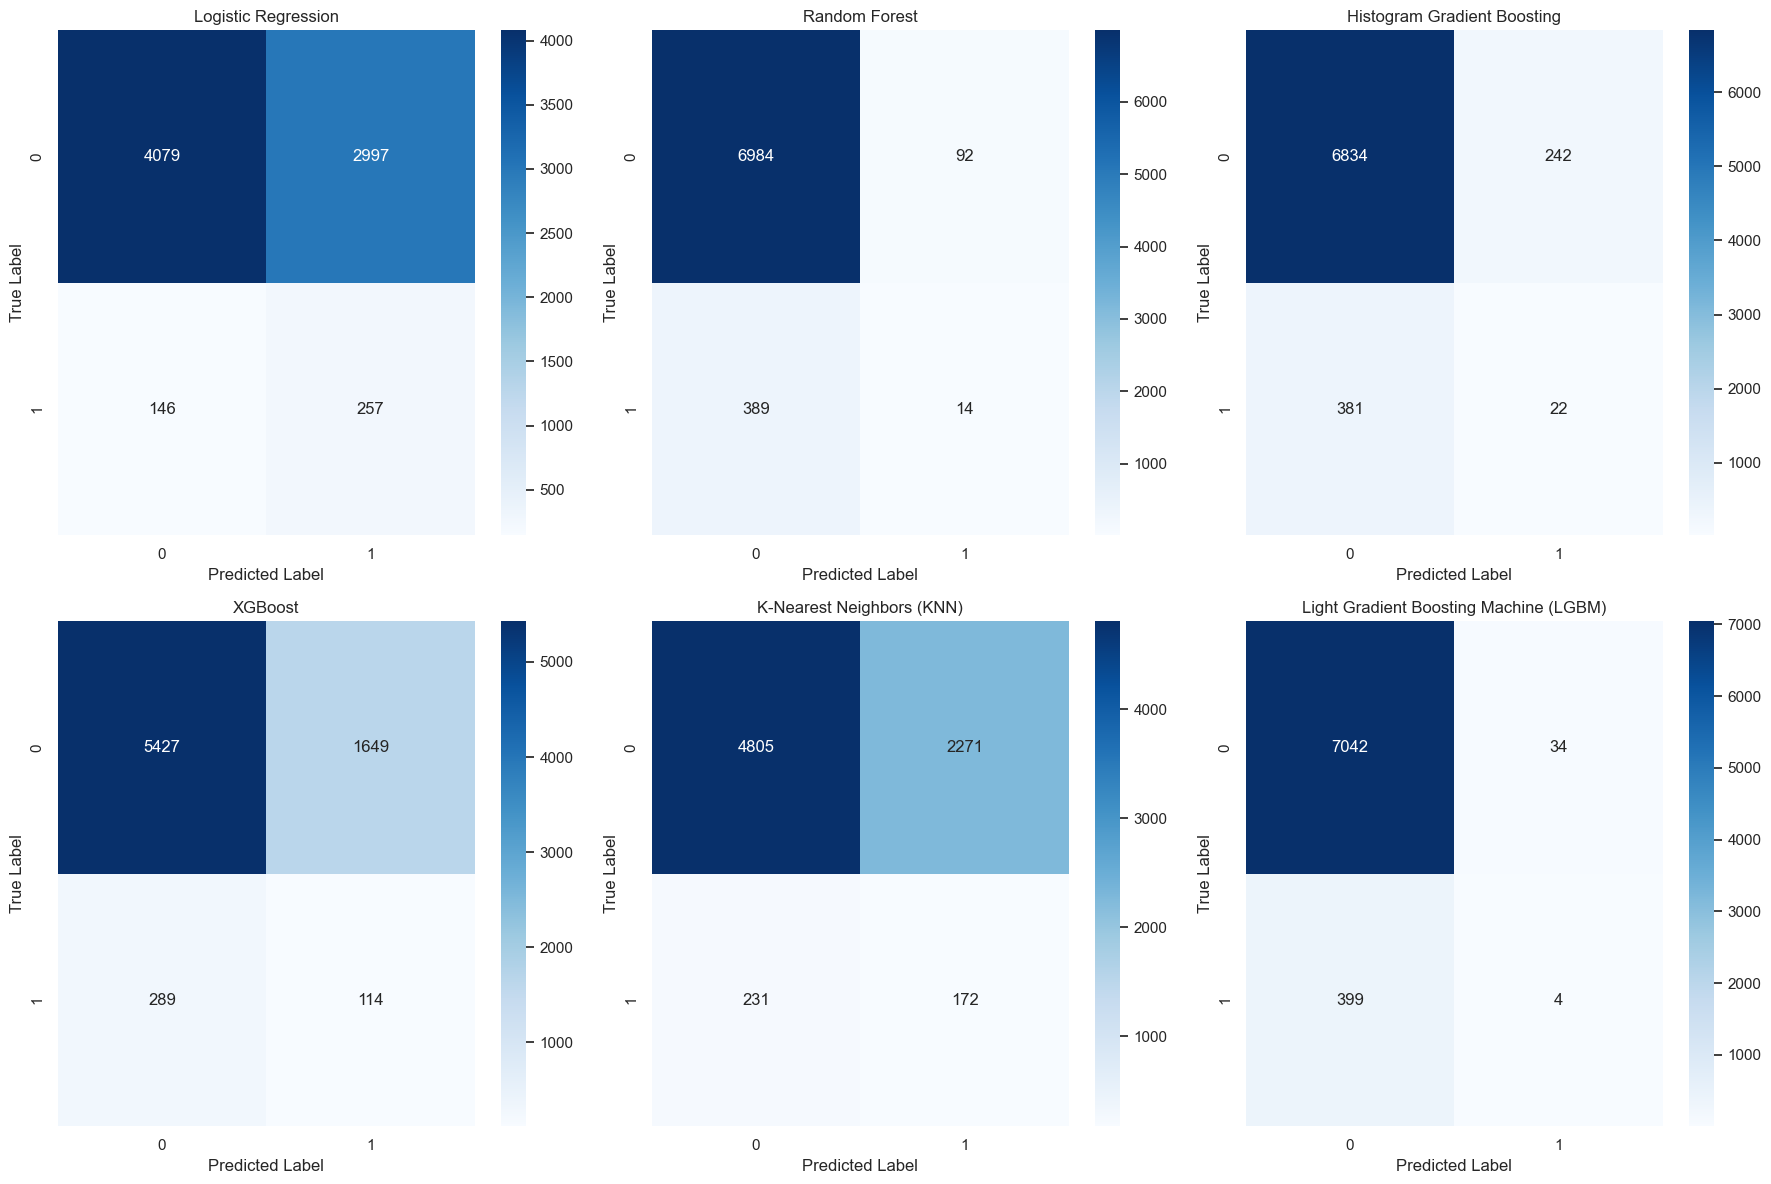

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
results = []
place = 0

# Model training loop with progress bar
for i, (model_name, model) in enumerate(tqdm(ml_models.items(), desc="Training models")):
    scale_numeric = model_name in models_that_need_scaling
    preprocessor = get_preprocessor(scale_numeric=scale_numeric)

    pipeline = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    param_grid = ml_models_parameters[model_name]

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=25,
        cv=2,
        scoring="f1",
        verbose=0,
        random_state=42,
        n_jobs=min(4, os.cpu_count()) 
    )

    with parallel_backend("loky"): 
        start_time = time.time()
        search.fit(df_train, y_train)
        end_time = time.time()

    best_model = search.best_estimator_
    best_score = search.best_score_
    y_pred = best_model.predict(df_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    y_probs = best_model.predict_proba(df_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_probs)
    cm = confusion_matrix(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)

    results.append({
        "Model": model_name,
        "Best Parameters": search.best_params_,
        "Best Score": best_score,
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "ROC AUC": roc_auc,
        "Time Taken (seconds)": round(end_time - start_time, 2)
    })

    print(f"\n{model_name} Report:")
    print(classification_report(y_valid, y_pred, digits=4))
    cm_matrix(cm=cm, place=i, model_name=model_name, axes=axes)
    place += 1

plt.tight_layout()
results_df = pd.DataFrame(results)

In [62]:
results_df = results_df.sort_values(
    by=["F1 Score", "ROC AUC"], 
    ascending=False)
results_df.to_csv(
    "models/results_df.csv", index=False)
results_df

,Model,Best Parameters,Best Score,Test Accuracy,Precision,Recall,F1 Score,Confusion Matrix,ROC AUC,Time Taken (seconds)
0,Logistic Regression,"{'model__solver': 'liblinear', 'model__penalty...",0.138659,0.579757,0.078980,0.637717,0.140552,"[[4079, 2997], [146, 257]]",0.632447,5.48
4,K-Nearest Neighbors (KNN),"{'model__weights': 'uniform', 'model__n_neighb...",0.126237,0.665463,0.070405,0.426799,0.120871,"[[4805, 2271], [231, 172]]",0.579790,458.90
3,XGBoost,"{'model__subsample': 0.7, 'model__n_estimators...",0.111121,0.740874,0.064663,0.282878,0.105263,"[[5427, 1649], [289, 114]]",0.564791,63.25
2,Histogram Gradient Boosting,"{'model__max_iter': 100, 'model__max_depth': 3...",0.093352,0.916700,0.083333,0.054591,0.065967,"[[6834, 242], [381, 22]]",0.621118,55.32
1,Random Forest,"{'model__n_estimators': 300, 'model__min_sampl...",0.031521,0.935687,0.132075,0.034739,0.055010,"[[6984, 92], [389, 14]]",0.620155,154.86
5,Light Gradient Boosting Machine (LGBM),"{'model__subsample': 1.0, 'model__num_leaves':...",0.027891,0.942105,0.105263,0.009926,0.018141,"[[7042, 34], [399, 4]]",0.654157,19.29


- We get the best model out of 6 different ones.
- We have created a save point here by extracting model parameters with all accuracy parameters to separate CSV.

### Final Model
To check the performance by the best model, we can load it from CSV file, select the top one and also run cross validation again with higher number to check how well it perform.

In [63]:
# Load results from previous experiment
results_df = pd.read_csv("models/results_df.csv")
results_df["Best Parameters"] = results_df["Best Parameters"].apply(clean_params)

In [64]:
# Sort the DataFrame by Test Accuracy or your preferred metric
best_model_row = results_df.loc[results_df["F1 Score"].idxmax()]
model_name = best_model_row["Model"]
best_params = best_model_row["Best Parameters"]

In [65]:
# Extract the model class from the dictionary
best_model_class = ml_models[model_name]

In [66]:
# Build preprocessor
scale_numeric = model_name in models_that_need_scaling
preprocessor = get_preprocessor(scale_numeric=scale_numeric)

In [67]:
# Reconstruct the best model pipeline with its parameters
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", best_model_class)
])

# Define param grid
param_grid = ml_models_parameters[model_name]

In [77]:
# Run an improved hyperparameter search
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=75,            
    cv=10,                  
    scoring="f1",          
    verbose=1,
    random_state=42,
    n_jobs=min(4, os.cpu_count())
)

In [78]:
with parallel_backend("loky"):
    start_time = time.time()
    search.fit(df_train, y_train)
    end_time = time.time()

# Get best model
final_model = search.best_estimator_
print("Best Hyperparameters from final search:")
print(search.best_params_)
print(f"Time taken: {round(end_time - start_time, 2)} seconds")

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Best Hyperparameters from final search:
{'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__max_iter': 50, 'model__class_weight': None, 'model__C': 1.25}
Time taken: 244.51 seconds


In [79]:
# Evaluate on test set
X_test_processed = preprocessor.fit_transform(df_test)
y_pred = final_model.predict(df_test)
y_proba = final_model.predict_proba(df_test)[:, 1]

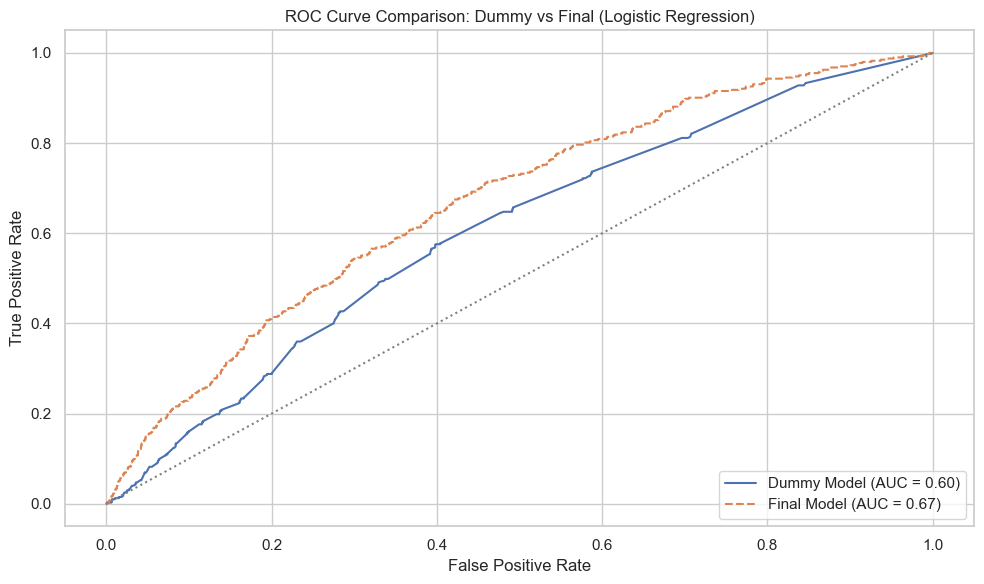

In [80]:
# Dummy pipeline (handles its own preprocessing)
dummy_proba_test = dummy_pipeline.predict_proba(df_test)[:, 1]

# === Compute ROC curves ===
from sklearn.metrics import roc_curve, auc

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_proba_test)
auc_dummy = auc(fpr_dummy, tpr_dummy)

fpr_final, tpr_final, _ = roc_curve(y_test, y_proba)
auc_final = auc(fpr_final, tpr_final)

plt.figure(figsize=(10, 6))
plt.plot(fpr_dummy, tpr_dummy, label=f"Dummy Model (AUC = {auc_dummy:.2f})")
plt.plot(fpr_final, tpr_final, linestyle="--", label=f"Final Model (AUC = {auc_final:.2f})")
plt.plot([0, 1], [0, 1], linestyle=":", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve Comparison: Dummy vs Final ({model_name})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

In [92]:
# Classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.9673    0.5979    0.7390      7075
           1     0.0837    0.6452    0.1482       403

    accuracy                         0.6004      7478
   macro avg     0.5255    0.6215    0.4436      7478
weighted avg     0.9197    0.6004    0.7072      7478



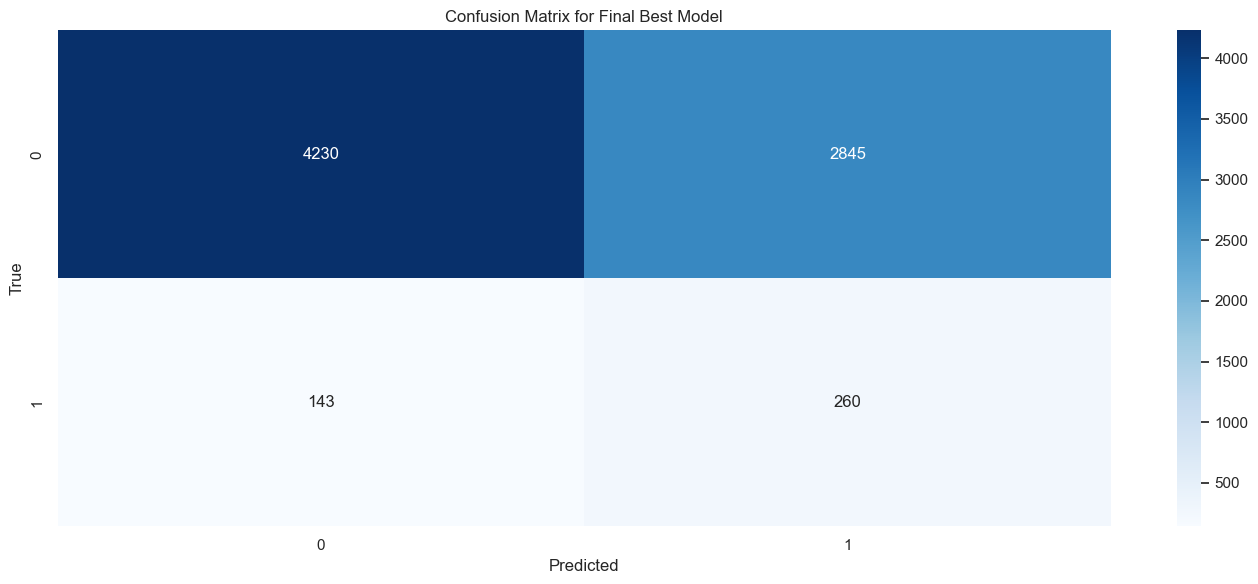

In [93]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt=".4g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Final Best Model")

plt.tight_layout()
plt.show()

In [94]:
model_summary = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_proba)
}

pd.DataFrame([model_summary])

,Accuracy,Precision,Recall,F1,ROC AUC
0,0.600428,0.083736,0.645161,0.148233,0.668125


In [95]:
joblib.dump(final_model, "models/final_best_model.pkl")

['models/final_best_model.pkl']

#### ROC Curve and Cross-Validation Results for Best Model

We evaluated the performance of the best-performing model — **Random Forest Classifier** — using the ROC curve and 10-fold cross-validation.

**ROC Curve**
- The ROC curve compares the true positive rate (TPR) and false positive rate (FPR) across different thresholds.
- The **Random Forest Classifier**(RFC) significantly outperforms the **Dummy Model**, which is RFC without any hyperparameter tuning.
- **AUC (Area Under Curve)** values:
  - **Random Forest**: **0.66**
  - **Dummy Model**: **0.60**
    
This indicates that the Random Forest model is able to  distinguish between the positive and negative classes better than random guessing, even with class imbalance.

## Summary

**Data Sources**
1. **Quotes & Policies Dataset**: Contains records of customer quote requests and whether they converted into an insurance policy (**POLICY** = 1 or 0).  
2. **Vehicle Features Dataset**: Includes detailed vehicle characteristics (e.g., power, weight, fuel type) for each quote.


### Approach
- **Data Preparation**: Merged quote and vehicle datasets to provide records with additional features.  
- **Exploratory Data Analysis**: Analyzed distributions and correlations to understand key patterns and improve feature engineering.  
- **Feature Engineering**: Created new features including:
  - **TOTAL_ACCIDENTS**, **HAVE_ACCIDENTS** 
  - **ACCELERATION** (power-to-weight ratio)
  - **POWER_PER_LITER**
  - **AGE_START_DRIVING**

- **Correlation Analysis**:
  - Removed multicollinearity features (**ACCIDENTS_LOCAL**, **ACCIDENTS_ABROAD**, **DRIVING_EXPERIENCE**)
  - Identified moderate correlation between **CUSTOMERAGE** and **AGE_START_DRIVING** (0.57), and between **ACCELERATION** and **POWER_PER_LITER** (0.66)

- **Modeling**:
  - Trained and evaluated multiple classifiers (Random Forest, XGBoost, LGBM, Logistic Regression, etc.)
  - Used F1-Score and ROC-AUC as primary metrics to handle class imbalance
  - Performed hyperparameter tuning using RandomizedSearchCV


### Key Results
- **Best Model**: Random Forest with an F1-Score of ~0.15 and ROC-AUC of ~0.66  
- **Cross-validated ROC-AUC**: ~0.63  
- **Class Imbalance**: Only 5.39% of quotes converted to policies. Make us use class weighting and proper evaluation metrics  

### **Feature Distributions**
**ACCELERATION**  
- Converted customers had slightly lower average acceleration  
- Suggests customers with slower vehicles may be more likely to convert  

**POWER_PER_LITER**  
- Similar trend to acceleration — converters have lower performance profiles  
- Indicates that vehicles with lower engine power efficiency are more likely to result in policy purchase  

**DRIVING_EXPERIENCE**  
- Most customers have 10–28 years of experience, with spikes at 8, 15, 25, and 50 years  
- Distribution is similar for both converted and non-converted quotes  
- Replaced with **AGE_START_DRIVING** for stronger insight.  

**VEHICLEAGE**  
- Peak vehicle age is 14–16 years  
- Converted quotes tend to come from newer vehicles (8–15 years)  


### **Additional Insights**
- **CUSTOMERAGE** and **DRIVING_EXPERIENCE** are highly correlated — dropped **DRIVING_EXPERIENCE** as we created **AGE_START_DRIVING**  
- **TOTAL_ACCIDENTS** and **HAVE_ACCIDENTS** show very high correlation (0.86) — to reduce redundancy, we stay with binary one
- No features had strong linear correlation with **POLICY**, supporting the use of non-linear models  

**BONUS_MALUS**  
- Groups H and G have the highest policy conversion rates (>6%)  
- Groups J and K have the lowest (~3%), over 2% below average  
- This feature is useful for segmentation  

**Fuel Type**  
- **Gasoline/Electric** shows highest conversion rate (7.08%)  
- **Diesel**, **Gasoline**, and **Electric** hover around 5.3–5.4%  
- **Gas (LPG)** had zero conversions, but sample size was only 3
- Fuel type with low counts was grouped into one  

**Policy Imbalance**  
- Only 5.39% of quotes are converted — accuracy is a misleading metric  
- Used F1-score, ROC-AUC, and custom thresholds for proper evaluation  


### Recommendations
- **Targeting**:
  - Focus marketing on segments with higher conversion rates:
    - BONUS_MALUS groups H and G
    - Gasoline/Electric fuel type
    - Vehicles aged 8–15 years
    - Customers with no accident history and modest engine specs

- **Modeling**:
  - Bin VEHICLEAGE and DRIVING_EXPERIENCE for better interpretability  
  - Use SHAP to understand model behavior  

- **Business Strategy**:
  - Increase offers to high-conversion groups like hybrid/electric owners  
  - Consider lowering price of low-performance vehicle owners  


### Deliverables
- Jupyter Notebook with full pipeline (data merge → preprocessing → modeling → evaluation)  
- Cleaned and documented code suitable for reuse or deployment  
- Summary report with business insights and model interpretation (this document)
